<br/>

## <div style="padding:10px;background-color:#9d5a47;margin:10;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 1px 10px;overflow:hidden;font-weight:50;width:auto">Linear Regression Homework</div>

### Import Libraries and Boilerplate Code

In [1]:
# Homework code goes here
from helper_functions import *

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

from IPython.display import Markdown, display

import itertools

import pandas as pd
import numpy as np
np.random.seed(42)

rng = np.random.default_rng(42)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'retina'


### Loading the Data

In [2]:
# Load the California housing dataset
housing = fetch_california_housing()

# Convert to pandas DataFrame
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df["target"] = housing.target * 100_000  # Convert to dollars

print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [3]:
display(df.head())

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude    target  
0    -122.23  452600.0  
1    -122.22  358500.0  
2    -122.24  352100.0  
3    -122.25  341300.0  
4    -122.25  342200.0

# EDA

### Descriptive Statistics

In [4]:
# Descriptive Statistics
display(df.describe().T)

count           mean            std           min  \
MedInc      20640.0       3.870671       1.899822      0.499900   
HouseAge    20640.0      28.639486      12.585558      1.000000   
AveRooms    20640.0       5.429000       2.474173      0.846154   
AveBedrms   20640.0       1.096675       0.473911      0.333333   
Population  20640.0    1425.476744    1132.462122      3.000000   
AveOccup    20640.0       3.070655      10.386050      0.692308   
Latitude    20640.0      35.631861       2.135952     32.540000   
Longitude   20640.0    -119.569704       2.003532   -124.350000   
target      20640.0  206855.816909  115395.615874  14999.000000   

                      25%            50%            75%            max  
MedInc           2.563400       3.534800       4.743250      15.000100  
HouseAge        18.000000      29.000000      37.000000      52.000000  
AveRooms         4.440716       5.229129       6.052381     141.909091  
AveBedrms        1.006079       1.048780       1.099526      34.066667  
Population     787.000000    1166.000000    1725.000000   35682.000000  
AveOccup         2.429741       2.818116       3.282261    1243.333333  
Latitude        33.930000      34.260000      37.710000      41.950000  
Longitude     -121.800000    -118.490000    -118.010000    -114.310000  
target      119600.000000  179700.000000  264725.000000  500001.000000

In [5]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


None

In [6]:
df.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

#### Mapping the Large Population Districts with Folium

Note: 
* This is a bonus section - so we can understand the data better. You haven't learned mapping, so you aren't responsible for this code - it's just so you can see what is possible.
* Folium is a Python library that allows you to create interactive maps. It is a great tool to visualize data on a map.
* Folium can be installed with `conda install folium`
* Notice two large population clusters on the map - near LA and SF

In [7]:
import folium

f = folium.Figure(width=800, height=500)
m = folium.Map(
    location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=6
).add_to(f)
for loc in df.query("Population > 2000").itertuples():
    folium.CircleMarker(
        location=[loc.Latitude, loc.Longitude],
        radius=loc.Population / 1500,
        color="red" if loc.Population > 10000 else "cornflowerblue",
        stroke=False,
        fill=True,
        fill_opacity=0.4,
        opacity=1,
        # popup="{} pixels".format(10),
    ).add_to(m)
m

#### Mapping the Districts with the Most Expensive Homes

In [8]:
import folium

f = folium.Figure(width=800, height=500)
m = folium.Map(
    location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=6
).add_to(f)
for loc in df.query("target > 300000").itertuples():
    folium.CircleMarker(
        location=[loc.Latitude, loc.Longitude],
        radius=loc.target / 100000,
        color="red" if loc.target > 499999 else "cornflowerblue",
        stroke=False,
        fill=True,
        fill_opacity=0.2,
        opacity=1,
        # popup="{} pixels".format(10),
    ).add_to(m)
m

### Target Distribution

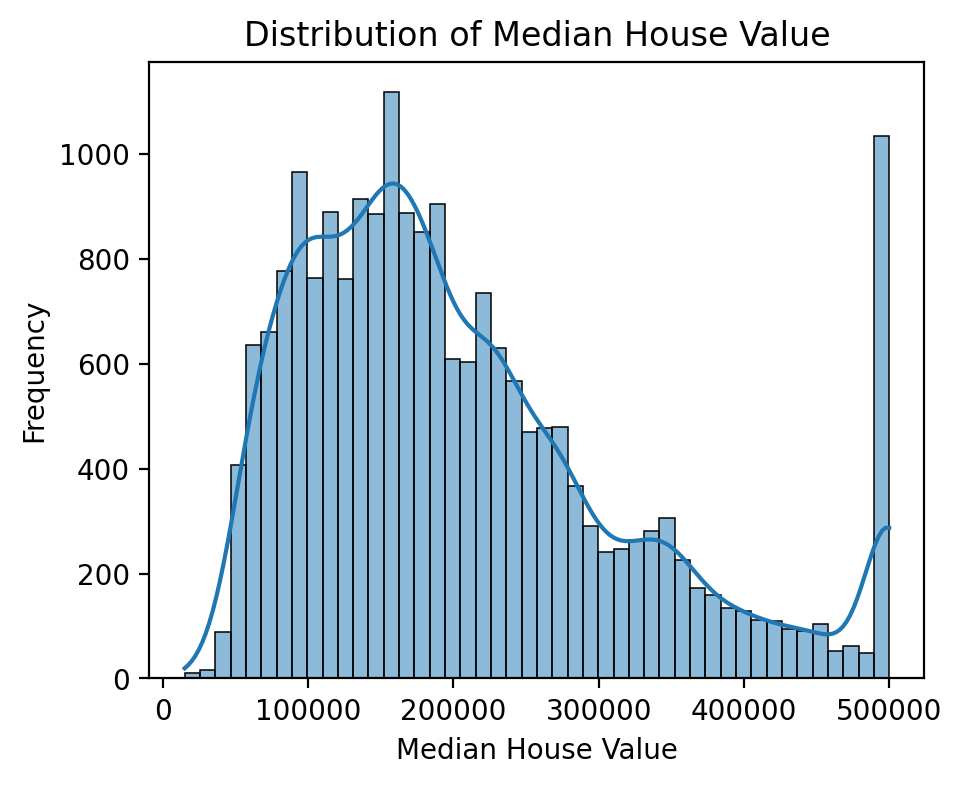

In [9]:
# Distribution of target variable
plt.figure(figsize=(5, 4))
sns.histplot(df["target"], kde=True)
plt.title("Distribution of Median House Value")
plt.xlabel("Median House Value")
plt.ylabel("Frequency")
plt.show()

<br/>
<div style="color:white; background:#478b9d;width:auto;max-width:800px;padding:40px; margin:0 auto;font-size:120%;text-align:center;">
<div>What's weird about the above? And why would the histogram look like that?</div>
</div>

#### Analyzing the Outlier where target > 5

In [10]:
display(Markdown("#### Target Has been cut off?"))
display(df.query("target > 5").head())
display(
    Markdown(
        f"#### Num rows where target > 5 : <b>{df.query('target > 5').shape[0]}</b>"
    )
)
display(
    Markdown(
        f"#### Percentage of rows where target > 5 : <b>{df.query('target > 5').shape[0] / df.shape[0] * 100:.2f}%</b>"
    )
)

#### Target Has been cut off?

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude    target  
0    -122.23  452600.0  
1    -122.22  358500.0  
2    -122.24  352100.0  
3    -122.25  341300.0  
4    -122.25  342200.0

#### Num rows where target > 5 : <b>20640</b>

#### Percentage of rows where target > 5 : <b>100.00%</b>

### Feature Distributions

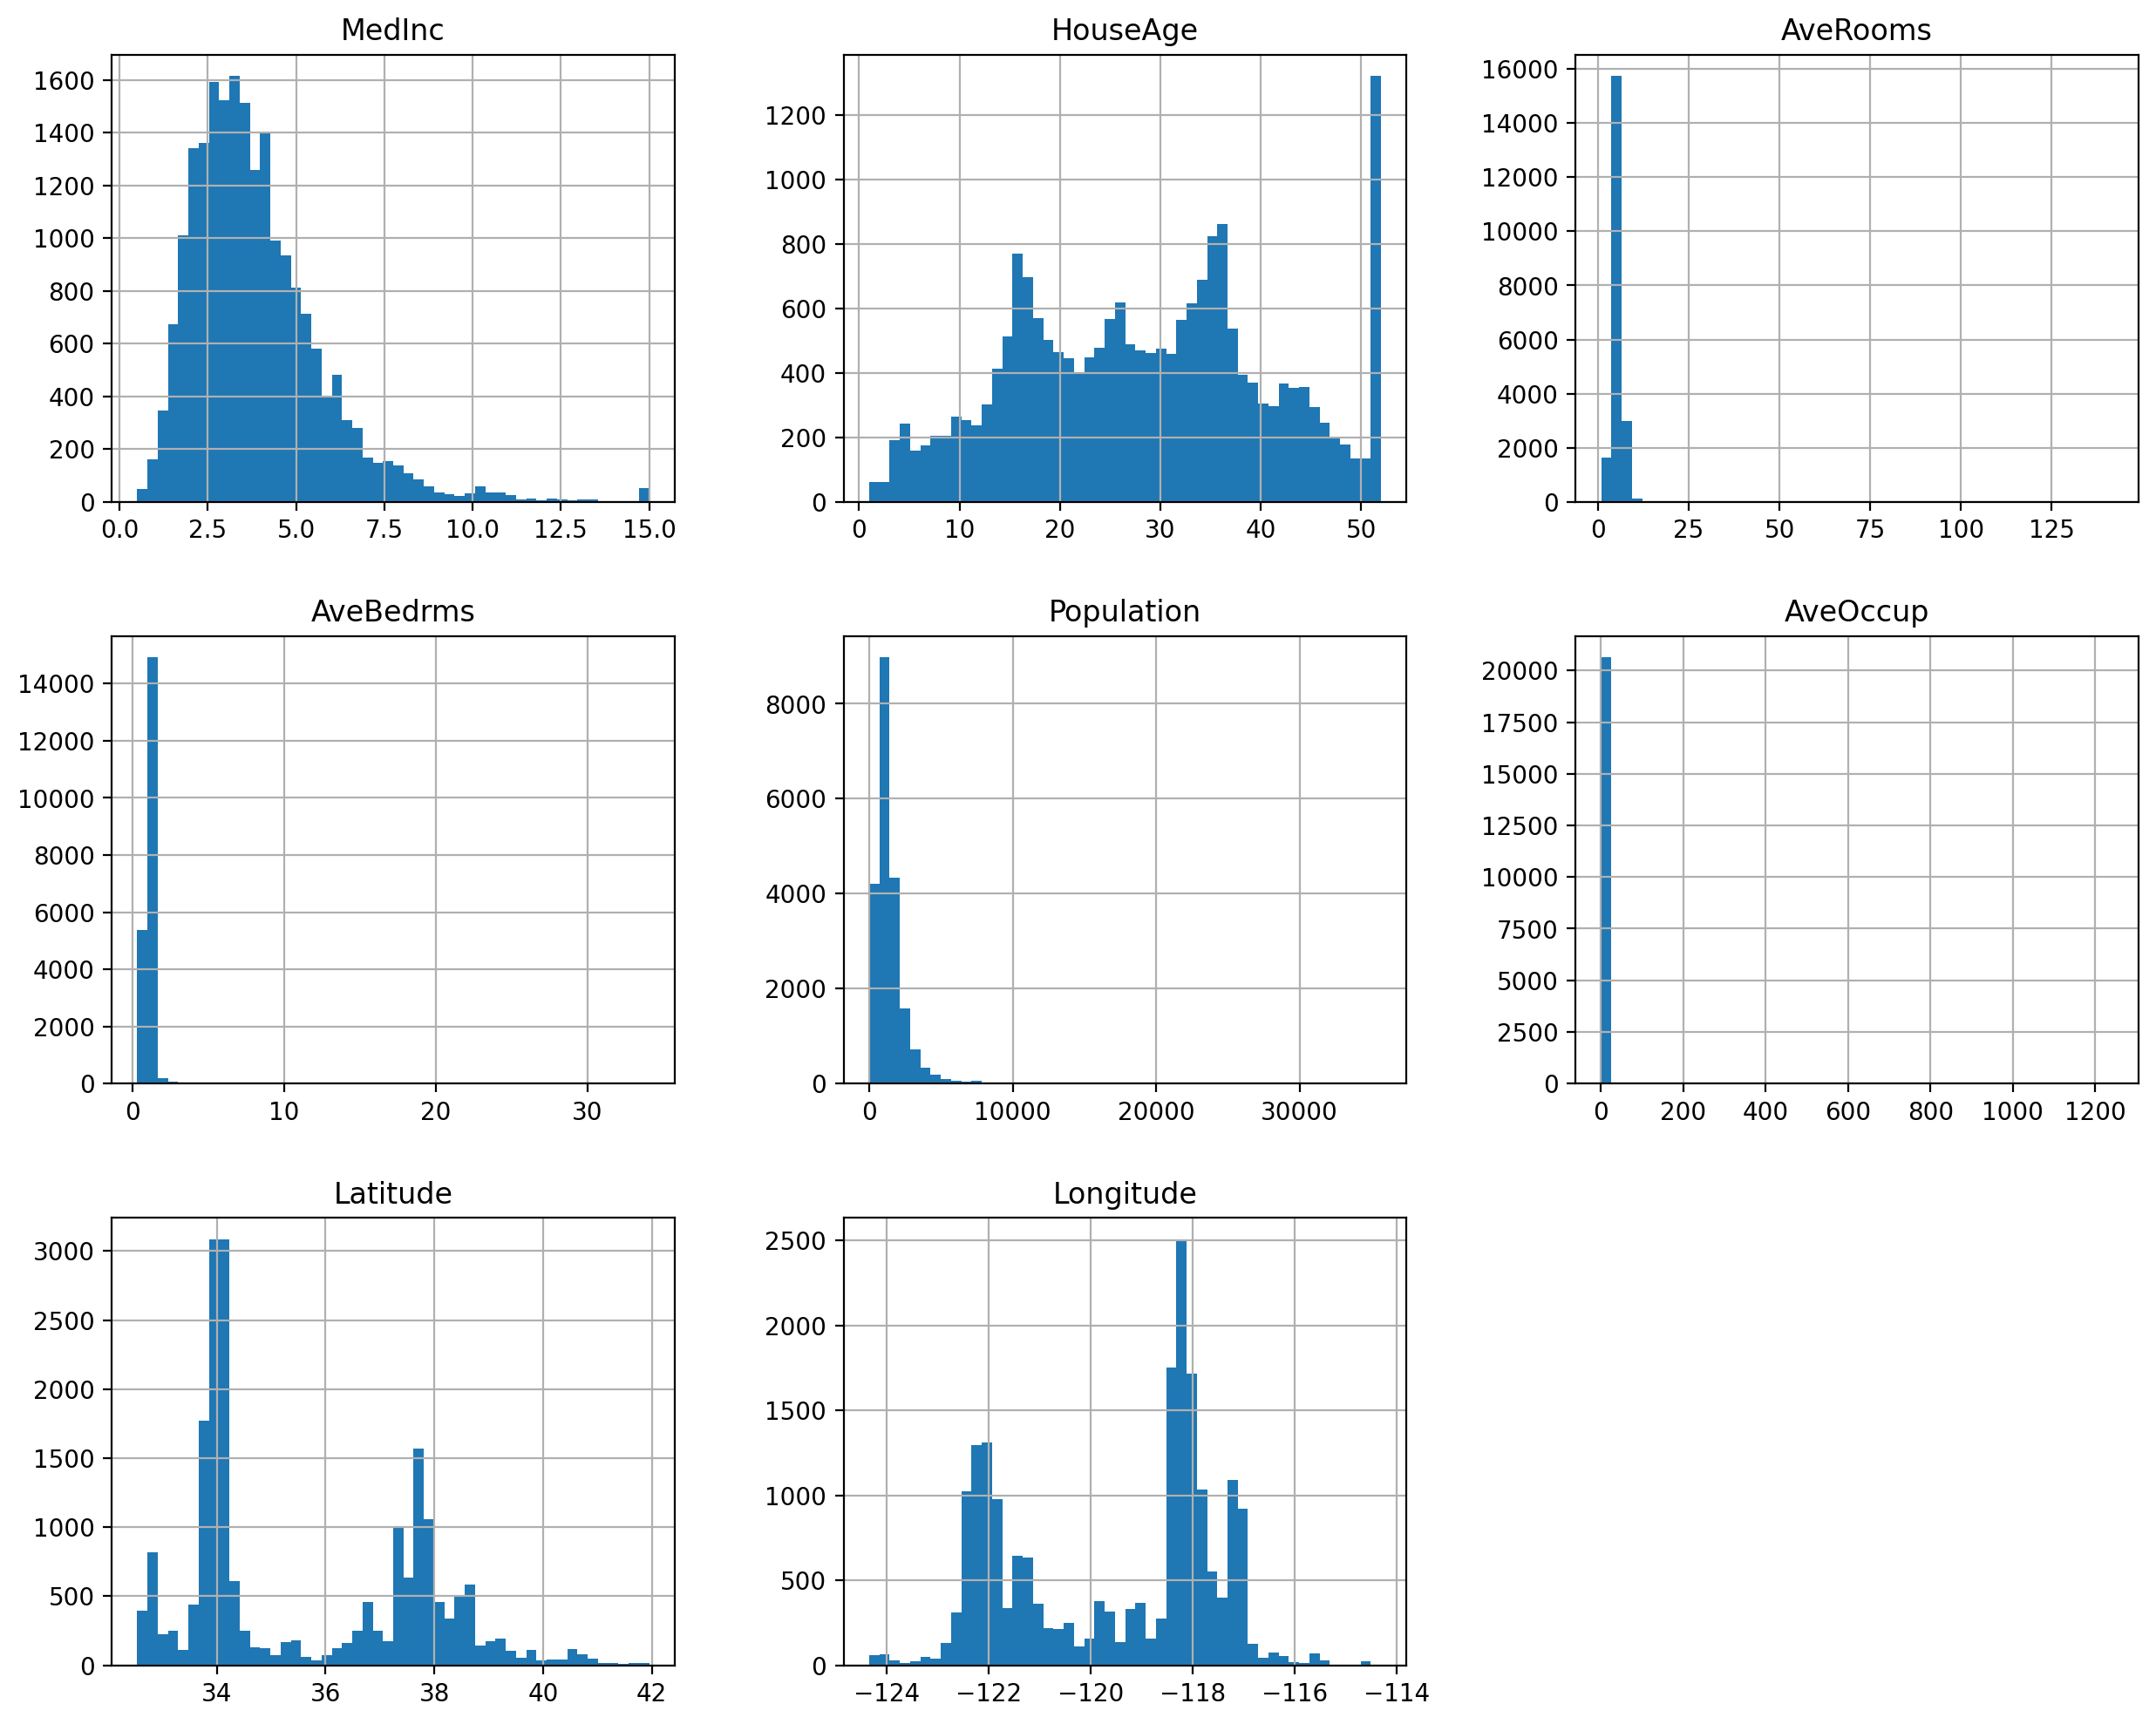

In [11]:
df.drop(columns="target").hist(bins=50, figsize=(15, 12))
plt.show()

# 

### Checking Colinearity

#### Correlation Matrix

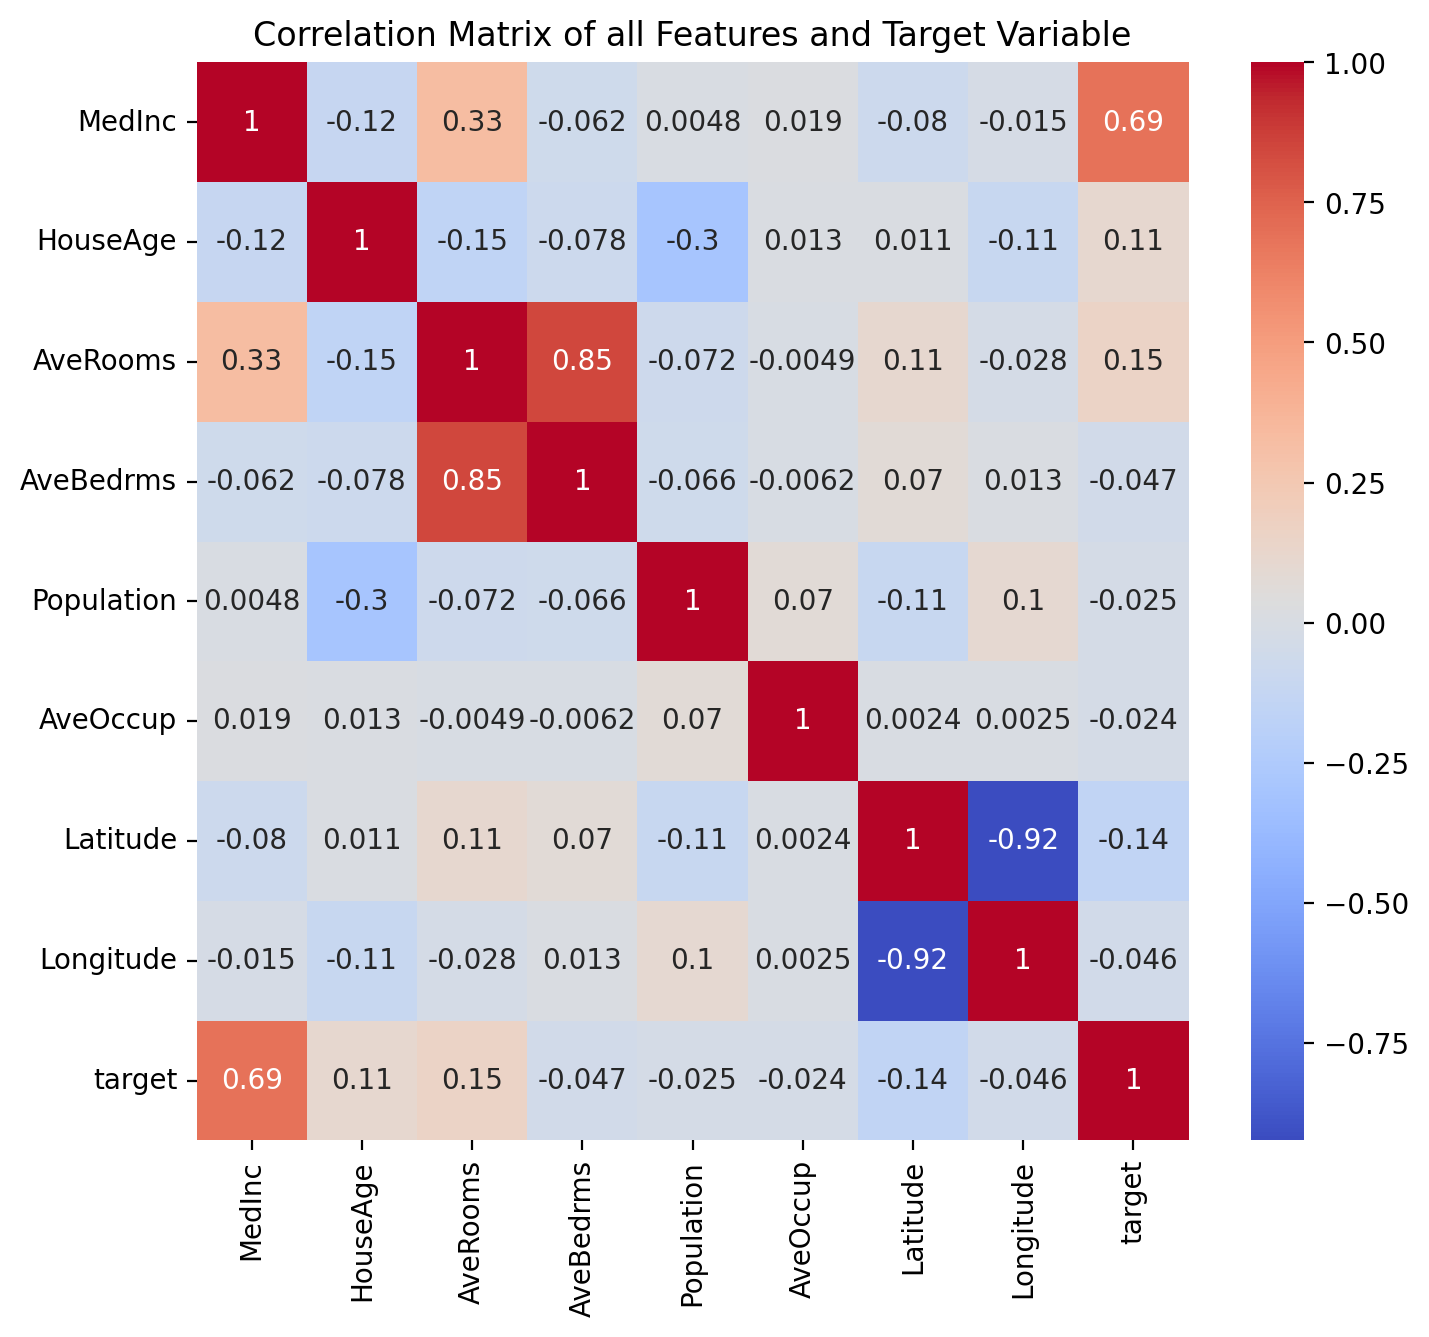

In [12]:
# Correlation matrix
plt.figure(figsize=(8, 7))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of all Features and Target Variable")
plt.show()

<br/>
<div style="color:white; background:#478b9d;width:auto;max-width:800px;padding:40px; margin:0 auto;font-size:120%;text-align:center;">
<div>Question: Which variables are highly correlated</div>
</div>

<br/>
<div style="color:white; background:#478b9d;width:auto;max-width:800px;padding:40px; margin:0 auto;font-size:120%;text-align:center;">
<div>Question: Which feature is fairly correlated to the target?</div>
</div>

### Pairplots

<Figure size 800x800 with 0 Axes>

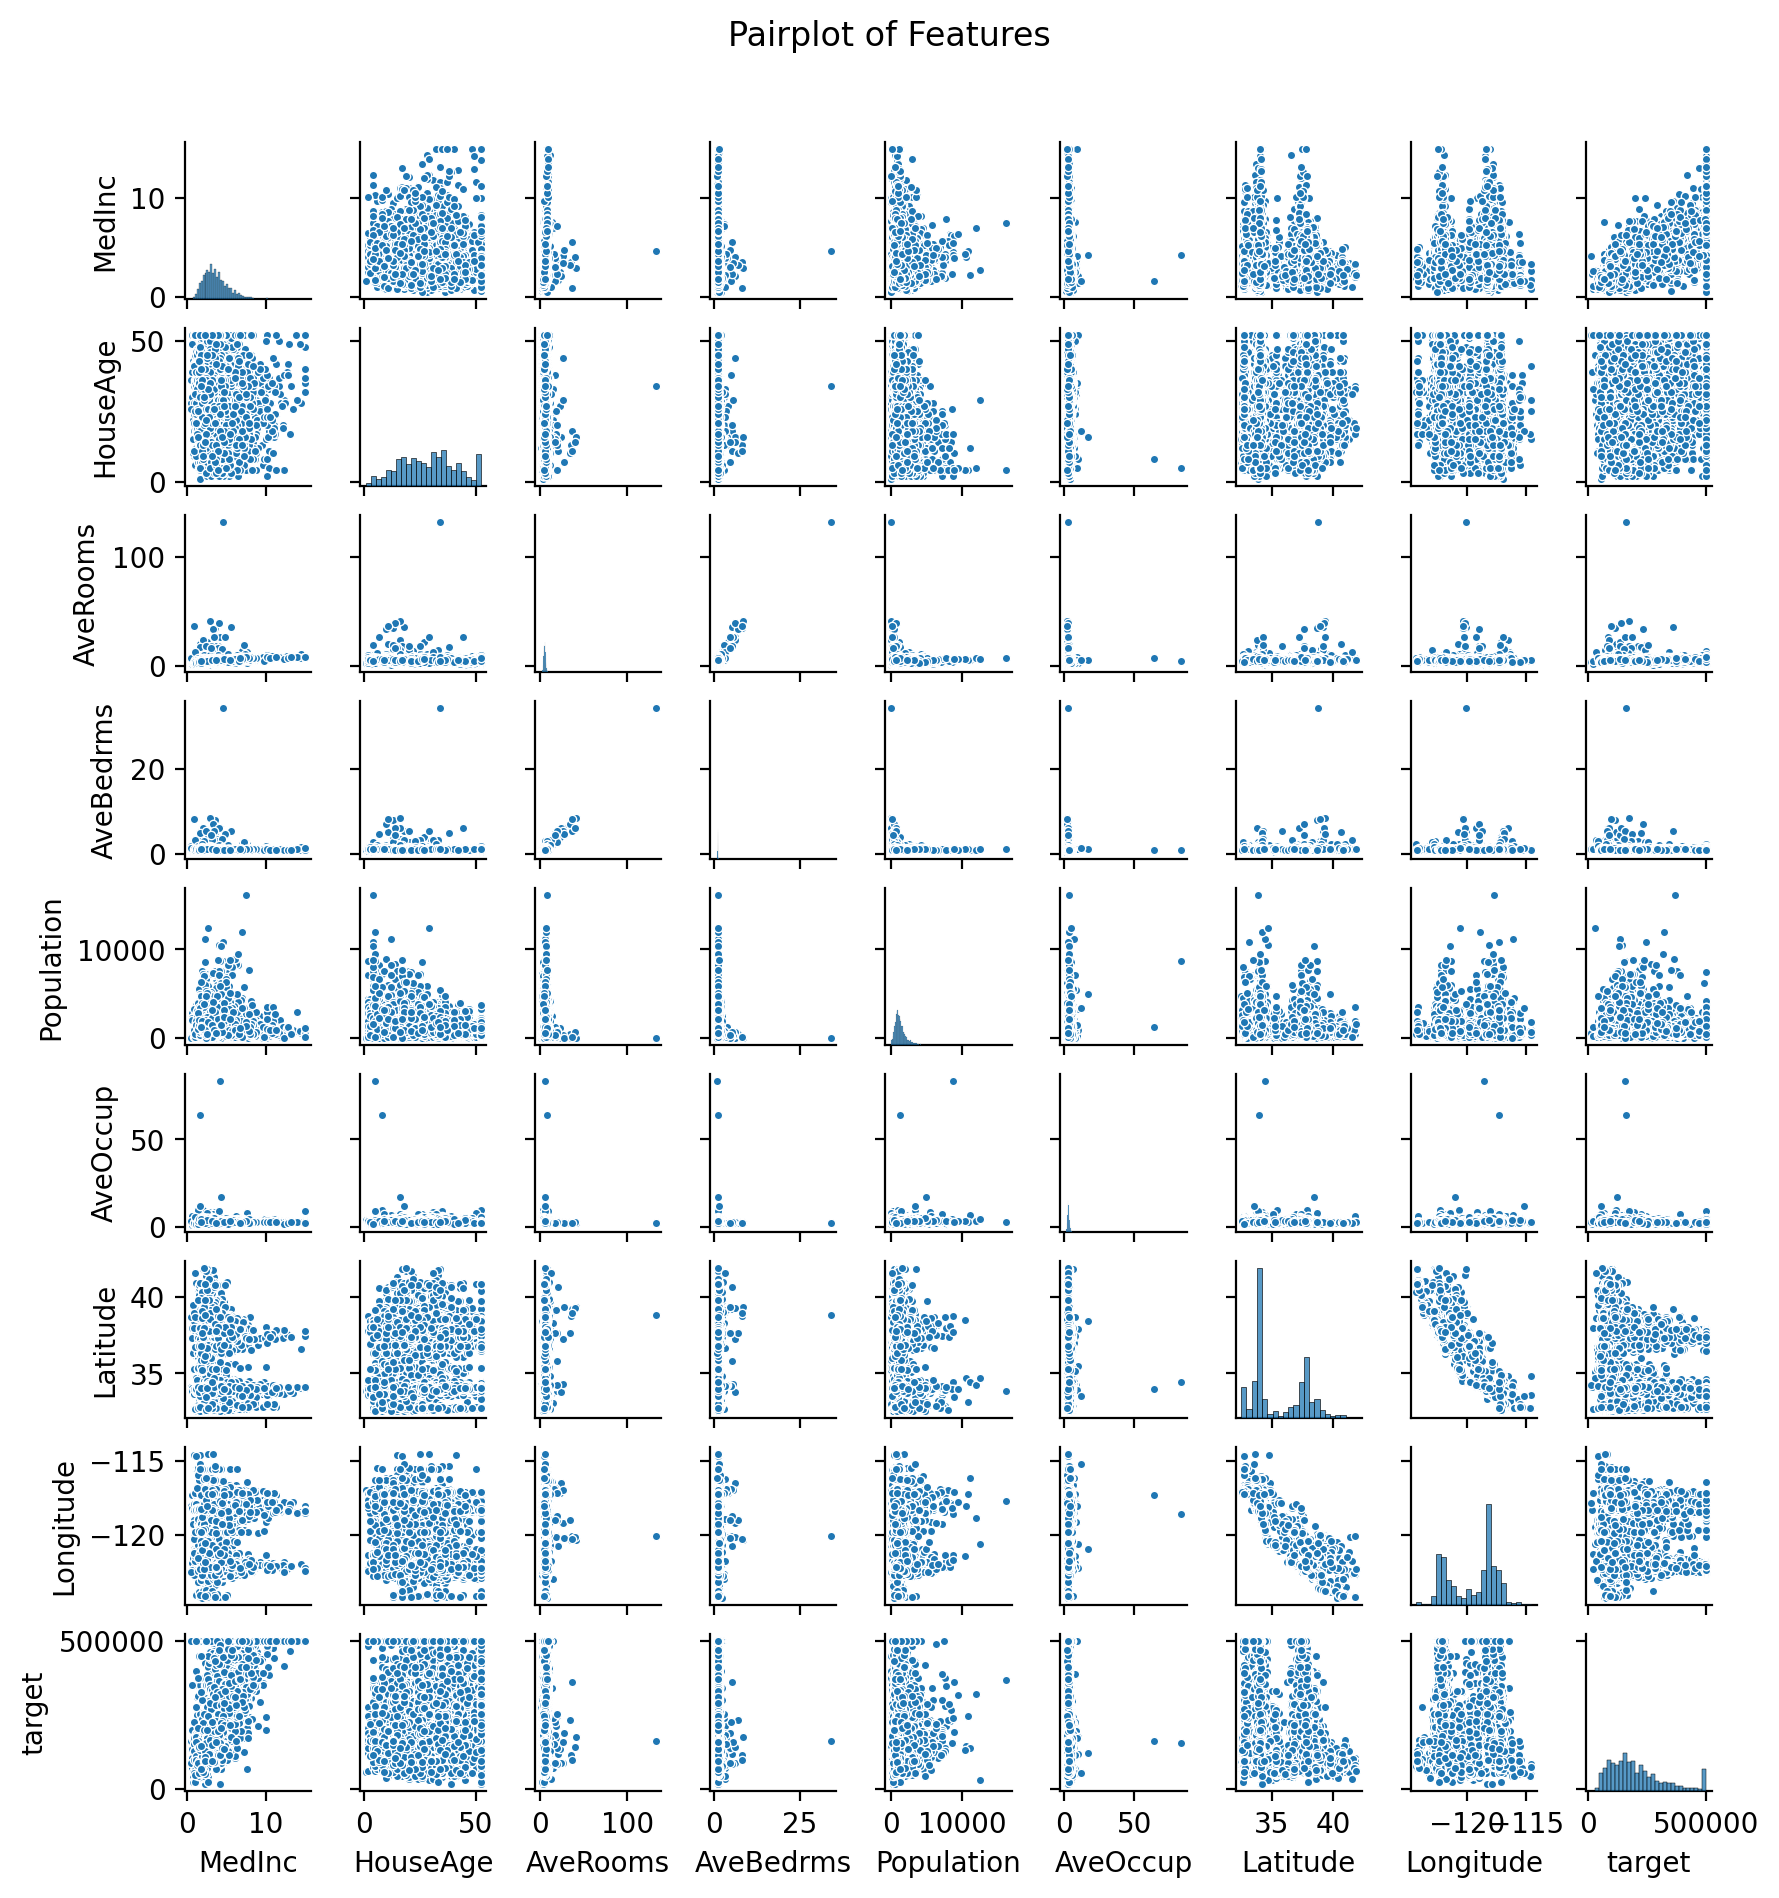

In [13]:
# Create a pairplot
plt.figure(figsize=(8, 8))
sns.pairplot(df.sample(5000), height=1, markers=".")
plt.suptitle("Pairplot of Features", y=1.05)
plt.show()

## Checking for Outliers

<br/>
<div style="color:white; background:#478b9d;width:auto;max-width:800px;padding:40px; margin:0 auto;font-size:120%;text-align:center;">
<div>Question: Which of the above pairs seem to have distinct outliers?</div>
</div>


### Violin Plots

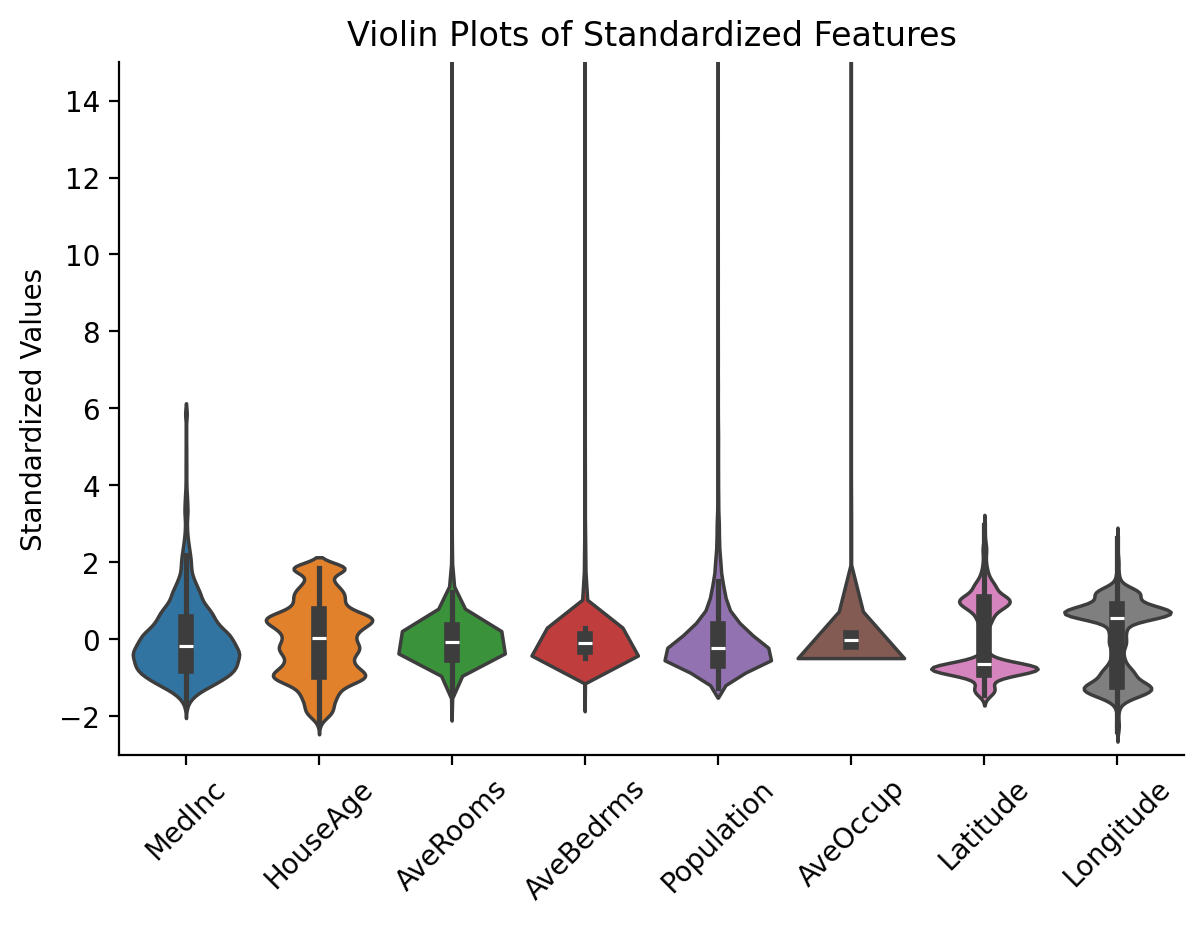

In [14]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform="pandas")
df_scaled = scaler.fit_transform(df.drop("target", axis=1))

# Create a grid of violin plots with one row and three columns
sns.catplot(data=df_scaled, kind="violin", height=4, aspect=1.5)
plt.ylim(
    -3, 15
)  # set the ylimits due to the presence of extreme outliers effecting scale
plt.xticks(rotation=45)
plt.ylabel("Standardized Values")
plt.title("Violin Plots of Standardized Features")
plt.show()

### Checking for outliers in the target variable

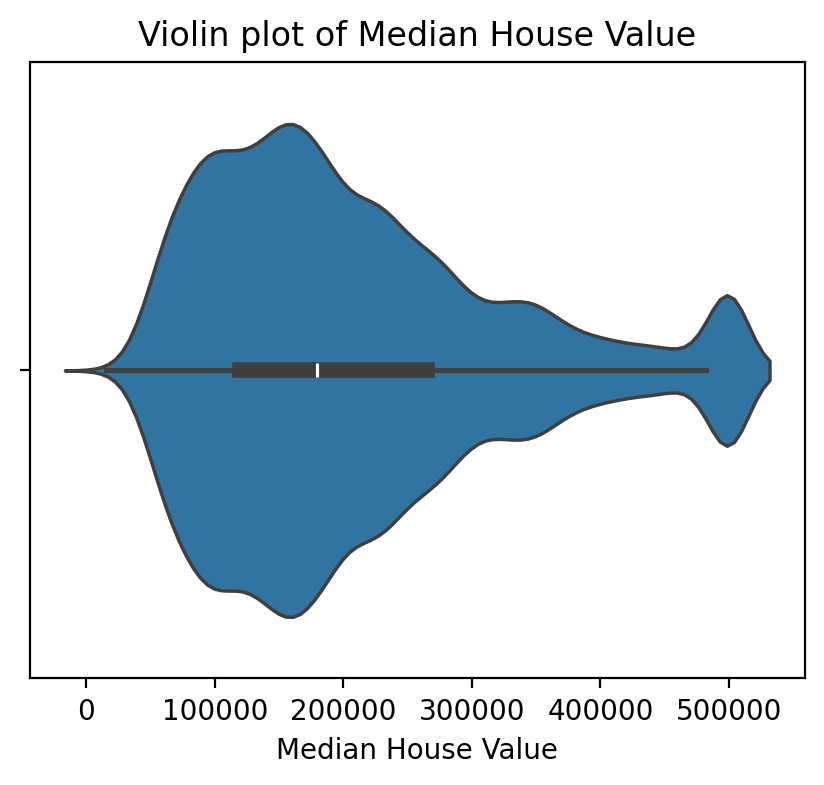

In [15]:
# Outliers in the target
plt.figure(figsize=(5, 4))
sns.violinplot(x="target", data=df)
plt.title("Violin plot of Median House Value")
plt.xlabel("Median House Value")
plt.show()

# Further analysis can be done based on specific questions or hypotheses.

In [16]:
from scipy import stats

# drop values where larger than 3 standard deviations in all features except target
df = df[(np.abs(stats.zscore(df.drop("target", axis=1))) < 3).all(axis=1)]

# drop values where target > 5
# we won't keep this data - just use it for visualization.
# we will revisit this later when we have split our data into train and test.
# we will only remove them from the training set and see if it improves our model or not.
df_temp = df.query("target <= 500000")

df_temp

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude    target  
0        -122.23  452600.0  
1        -122.22  358500.0  
2        -122.24  352100.0  
3        -122.25  341300.0  
4        -122.25  342200.0  
...          ...       ...  
20635    -121.09   78100.0  
20636    -121.21   77100.0  
20637    -121.22   92300.0  
20638    -121.32   84700.0  
20639    -121.24   89400.0  

[19124 rows x 9 columns]

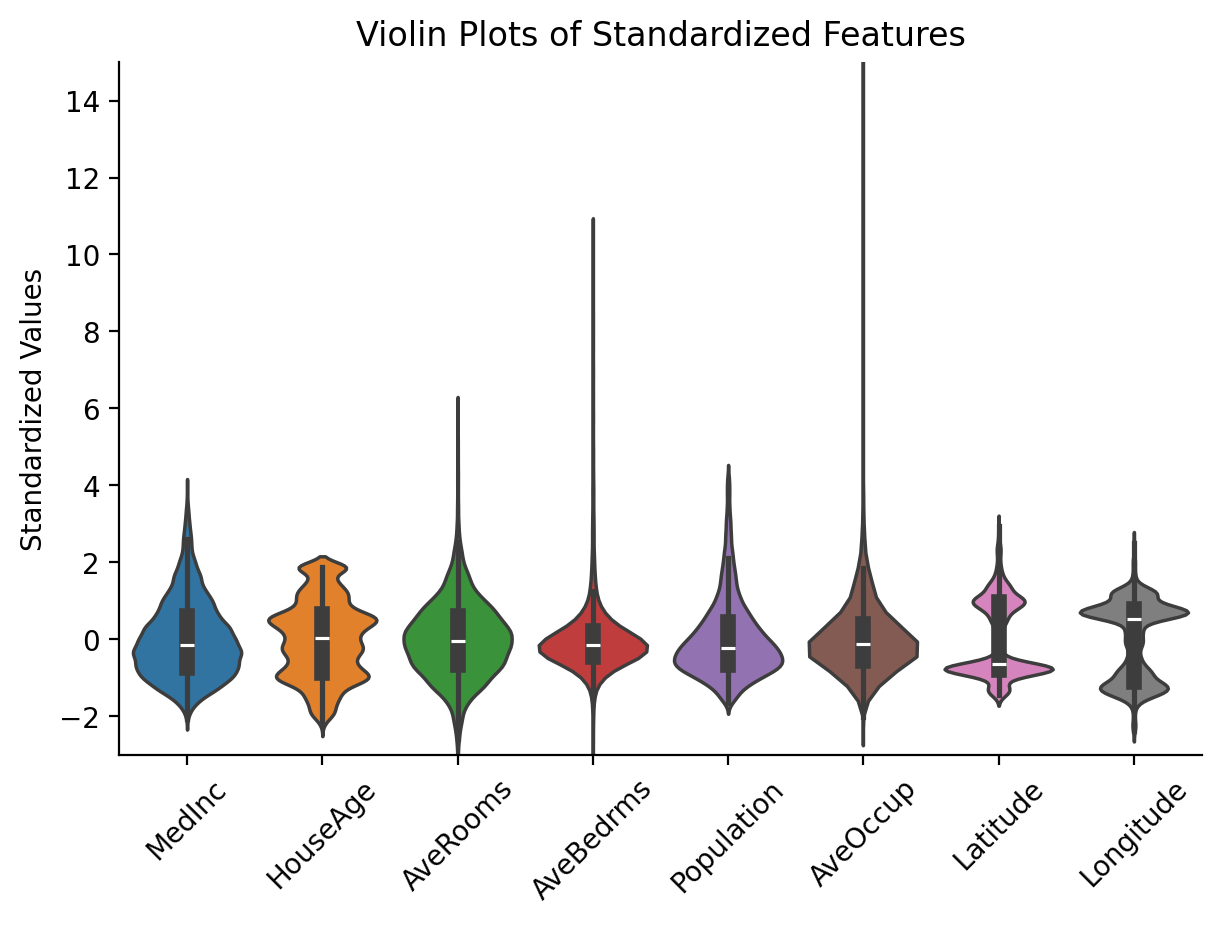

In [17]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform="pandas")
df_scaled = scaler.fit_transform(df_temp.drop("target", axis=1))

# Create a grid of violin plots with one row and three columns
sns.catplot(data=df_scaled, kind="violin", height=4, aspect=1.5)
plt.ylim(
    -3, 15
)  # set the ylimits due to the presence of extreme outliers effecting scale
plt.xticks(rotation=45)
plt.ylabel("Standardized Values")
plt.title("Violin Plots of Standardized Features")
plt.show()

### Checking for outliers in the target variable

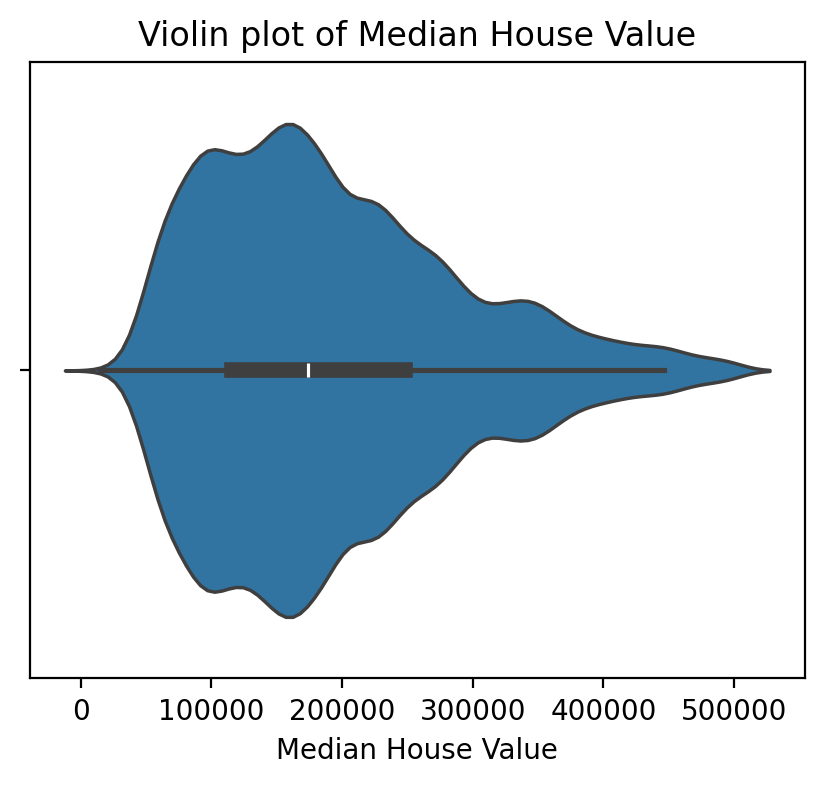

In [18]:
# Outliers in the target
plt.figure(figsize=(5, 4))
sns.violinplot(x="target", data=df_temp)
plt.title("Violin plot of Median House Value")
plt.xlabel("Median House Value")
plt.show()

# Further analysis can be done based on specific questions or hypotheses.

<br>
<div style="color:white; background:#9d8547; max-width:800px;padding:40px; margin:0 auto;font-size:120%;text-align:center;">
<div>HOMEWORK 1: Feature Engineering</div>
</div>

### Create a new feature that measure the distance of each house to the equatorial line

Notes:
1. latitude of the equatorial line is 0
2. latitude of the North Pole is 90
3. latitude of the South Pole is -90
4. We are looking for the absolute "distance" and we don't care if it's North or South
5. Bin the latitude lines into 10 bins using the `pd.cut` function
6. The function you need to implement is `create_equatorial_distance_feature` and the file is `helper_functions.py`

Side Note: This data is for California districts so the data is actually from around 32 for 42 degrees latitude

In [19]:
df = create_equatorial_distance_feature(df)
display(df.sample(5))

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
14519  4.0000      16.0  4.648973   0.994863      1619.0  2.772260     32.91   
7710   5.2015      37.0  6.194915   1.029661       600.0  2.542373     33.95   
7224   2.3438      42.0  3.779778   1.004155      3004.0  4.160665     34.02   
9038   2.4348      34.0  4.911290   1.149194       797.0  3.213710     34.74   
16693  3.3062      11.0  5.051421   1.124493      1839.0  2.488498     35.11   

       Longitude    target  distance_from_equator  distance_from_equator_bin  
14519    -117.13  154700.0                  32.91                          0  
7710     -118.14  302000.0                  33.95                          1  
7224     -118.15  154300.0                  34.02                          1  
9038     -118.09  104800.0                  34.74                          2  
16693    -120.61  158500.0                  35.11                          2

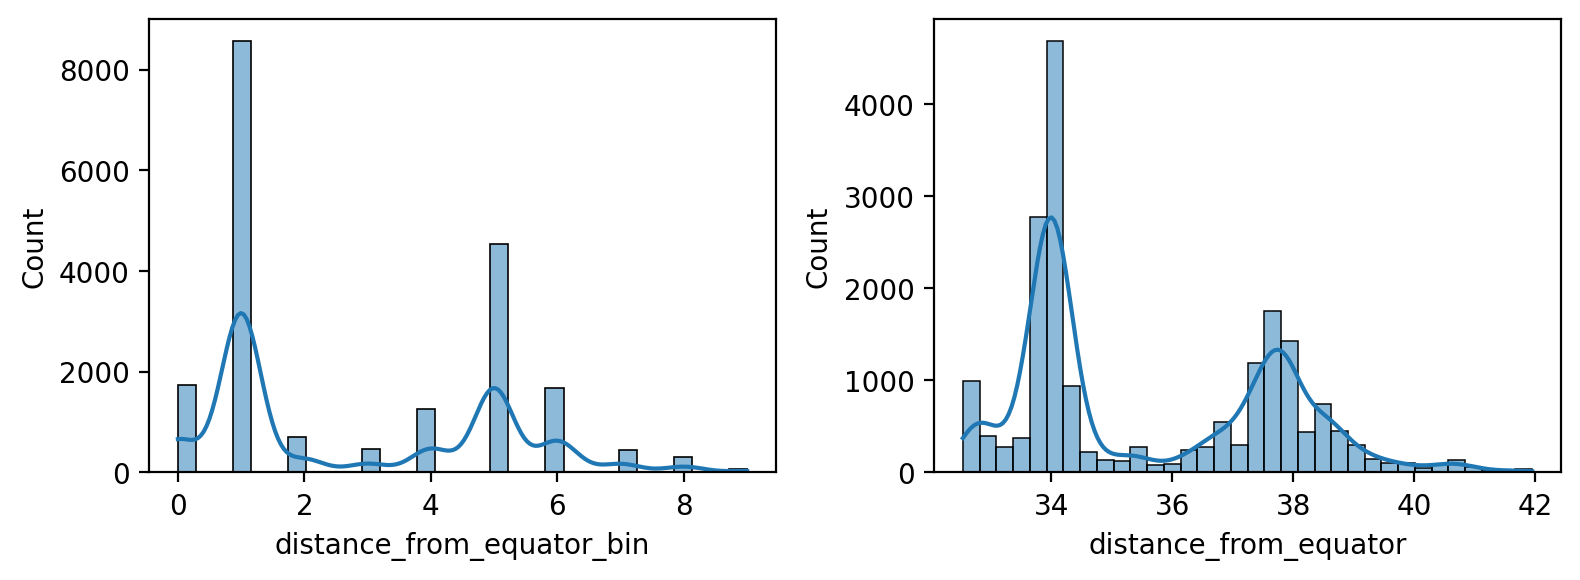

<b>Notice the 2 distinct spikes.  They may correspond to the areas near LA and SF</b>

In [20]:
# show a histogram of the new feature
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.histplot(df["distance_from_equator_bin"], kde=True, ax=ax[0])
sns.histplot(df["distance_from_equator"], kde=True, ax=ax[1])
plt.tight_layout()
plt.show()

display(
    Markdown(
        "<b>Notice the 2 distinct spikes.  They may correspond to the areas near LA and SF</b>"
    )
)

In [21]:
# combine the collinear features
df["AveRoomsAndBedrms"] = df["AveRooms"] * df["AveBedrms"]
df["LatLong"] = df["Latitude"] + df["Longitude"]

<br>
<div style="color:white; background:#9d8547; max-width:800px;padding:40px; margin:0 auto;font-size:120%;text-align:center;">
<div>HOMEWORK 2: Linear Regression</div>
</div>

### Create and test linear regression models

Generate models and metrics for the following:
1. No standardization and no target transform
2. Standardization and no target transform
3. Standardization and target transform

Accomplish these tasks by implementing the functions `linear_regression_pipeline`, `evaluate_model`, `scale_features`, and `transform_target` in `helper_functions.py`. Use all columns, including the feature engineered ones from the last problem and excluding "target" and the columns used to create the feature engineered columns, as features in all models.

# Modeling with Linear Regression

In [22]:
from dataclasses import dataclass
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import Ridge, LinearRegression, Lasso

In [23]:
feats = [
    x
    for x in df.columns
    if x not in ["target", "AveRooms", "AveBedrms", "Latitude", "Longitude"]
]

# Split the data into target and feature columns
X = df[feats]
y = df["target"]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [24]:
# run the model naive model
model_00, train_00, test_00 = linear_regression_pipeline(
    X_train, X_test, y_train, y_test
)

display(Markdown("## Model 00"))
display(Markdown("#### No standardization and no target transform"))
display(pretty_metrics(model_00, train_00, test_00))

## Model 00

#### No standardization and no target transform

model_name   data           mse          rmse           mae        r2
0  LinearRegression  train  4.727060e+09  68753.619090  50330.293483  0.614127
1  LinearRegression   test  4.942610e+09  70303.698091  51093.503839  0.599063

In [25]:
# Standardization and no target transform
X_train_scaled, X_test_scaled = scale_features(X_train.copy(), X_test.copy(), feats)
model_10, train_10, test_10 = linear_regression_pipeline(
    X_train_scaled, X_test_scaled, y_train, y_test
)

display(Markdown("## Model 10"))
display(Markdown("#### Yes standardization and no target transform"))
display(pretty_metrics(model_10, train_10, test_10))

## Model 10

#### Yes standardization and no target transform

model_name   data           mse          rmse           mae        r2
0  LinearRegression  train  4.727060e+09  68753.619090  50330.293483  0.614127
1  LinearRegression   test  4.942610e+09  70303.698091  51093.503839  0.599063

<br/>
<div style="color:white; background:#478b9d;width:auto;max-width:800px;padding:40px; margin:0 auto;font-size:120%;text-align:center;">
<div>Question: Why would standardization have no effect on a Linear Regression?</div>

<i style="font-size:80%">Hint 1: Think of how the coefficients are formed in a linear regression model. What ARE coefficients? 

Hint 2: The LinearRegression model is fit using `fit_intercept=True` by default. What does this mean?

Hint 3: What is Standardization? What 2 things does it do to the data?</i>

</div>



In [26]:
# Standardization and target transform
# we retain the transformer so we can use it to inverse transform the target
y_train_transformed, y_test_transformed, target_transformer = transform_target(
    y_train, y_test
)

model_11, train_11, test_11 = linear_regression_pipeline(
    X_train_scaled,
    X_test_scaled,
    y_train_transformed,
    y_test_transformed,
    target_transformer,  # pass the target transformer
)


display(Markdown("## Model 11"))
display(Markdown("#### Yes standardization and yes target transform"))
display(pretty_metrics(model_11, train_11, test_11))

## Model 11

#### Yes standardization and yes target transform

model_name   data           mse          rmse           mae        r2
0  LinearRegression  train  4.425048e+09  66521.037229  46179.259471  0.638780
1  LinearRegression   test  4.609259e+09  67891.521621  46627.896329  0.626104

<br>
<div style="color:white; background:#9d8547; max-width:800px;padding:40px; margin:0 auto;font-size:120%;text-align:center;">
<div>HOMEWORK 3: Feature Selection</div>
</div>

### Use backward stepwise selection to obtain best model using RMSE criteria

Accomplish these tasks by implementing the function `backward_stepwise` and using the previously implemented `linear_regression_pipeline`. Use all columns, including the feature engineered ones from the last problem and excluding "target" and the columns used to create the feature engineered columns, as the starting point for backward stepwise selection. Use the scaled and transformed dataframe from the previous problem.

Note: You may use code found online to help implement the function but make sure to include any necessary citations.

In [27]:
from helper_functions import *

In [28]:
feats

['MedInc',
 'HouseAge',
 'Population',
 'AveOccup',
 'distance_from_equator',
 'distance_from_equator_bin',
 'AveRoomsAndBedrms',
 'LatLong']

In [29]:
# best_model, best_feats, best_rmse = backward_stepwise(df_transformed, "target", feats)
best_idx, features_list, rmse_list = backward_stepwise_train(X_train, y_train, feats)

In [30]:
results_df = pd.DataFrame(
    {
        "Features": list(features_list.values()),
        "RMSE": rmse_list,
    }
).sort_values("RMSE")

results_df

Features          RMSE
0  [MedInc, HouseAge, Population, AveOccup, dista...  68091.296898
1  [MedInc, HouseAge, Population, AveOccup, dista...  68103.892236
2  [MedInc, HouseAge, Population, AveOccup, dista...  76625.817561
3  [MedInc, HouseAge, Population, AveOccup, dista...  76686.578653
4           [MedInc, HouseAge, Population, AveOccup]  77347.340661
5                     [MedInc, HouseAge, Population]  78578.118132
6                                 [MedInc, HouseAge]  82850.502668
7                                           [MedInc]  86589.656021

In [31]:
results_df.iloc[0].Features

['MedInc',
 'HouseAge',
 'Population',
 'AveOccup',
 'distance_from_equator',
 'distance_from_equator_bin',
 'AveRoomsAndBedrms',
 'LatLong']

<br>
<div style="color:white; background:#9d8547; max-width:800px;padding:40px; margin:0 auto;font-size:120%;text-align:center;">
<div>HOMEWORK 4: Regularization</div>
</div>

### Use LASSO to perform intrinsic feature selection

Accomplish this task by implementing the function `build_lasso_model`. Use all columns, including the feature engineered ones from HOMEWORK 2 and excluding "target" and the columns used to create the feature engineered columns. Use the scaled and transformed dataframe from the HOMEWORK 2. Experiment with values of alpha which seem to give the best value of RMSE.

In [32]:
alpha = 1
coefs, rmse = build_lasso_model(X_train, y_train, alpha)
print("LASSO Regression Coefficients: ", coefs)
print("LASSO Regression RMSE:", rmse)

LASSO Regression Coefficients:  [ 3.07904359e-02  1.45078564e-03  2.69808798e-05 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00]
LASSO Regression RMSE: 111862.05384229195


## The rest of this is just for fun.  It's a quick and dirty way to experiment with different features and see how they affect the model.

In [33]:
@dataclass
class ModelResults:
    model: object
    train_preds: np.ndarray
    test_preds: np.ndarray
    train_score: float
    test_score: float
    y_train: np.ndarray
    y_test: np.ndarray
    scalar: object
    features: list
    target: str

In [34]:
def train_linear(
    df,
    features="all",
    target="target",
    drop_outliers=3,
    scaler=None,
    target_transformer=False,
    model=LinearRegression(),
):
    if features == "all":
        features = df.columns.drop(target)

    X = df[features].values
    y = df[target].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    if drop_outliers:
        # drop values where larger than 3 standard deviations
        y_train = y_train[(np.abs(stats.zscore(X_train)) < 3).all(axis=1)]
        # also drop the x values
        X_train = X_train[(np.abs(stats.zscore(X_train)) < 3).all(axis=1)]

    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if target_transformer:
        y_train = target_transformer.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test = target_transformer.transform(y_test.reshape(-1, 1)).ravel()

    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    return ModelResults(
        model,
        train_preds,
        test_preds,
        train_score,
        test_score,
        y_train,
        y_test,
        scaler,
        features,
        target,
    )

In [35]:
# create a dataframe to store the results
results_df = pd.DataFrame(
    columns=["model_name", "train_score", "test_score", "features", "model", "params"]
)

# choose our models and features to use
models = [LinearRegression(), Ridge()]  # , Ridge(), Lasso()]

all_features = df.columns.drop("target")

features_to_use = [
    [
        "MedInc",
        "HouseAge",
        "AveRooms",
        "AveBedrms",
        "Population",
        "AveOccup",
        "Latitude",
        "Longitude",
        "distance_from_equator",
    ],
    [
        "MedInc",
        "HouseAge",
        "AveRooms",
        "AveBedrms",
        "Population",
        "AveOccup",
        "distance_from_equator",
    ],
    [
        "MedInc",
        "HouseAge",
        "AveRooms",
        "AveBedrms",
        "Population",
        "AveOccup",
        "Latitude",
        "Longitude",
    ],
    [
        "MedInc",
        "HouseAge",
        "AveRooms",
        "AveBedrms",
        "Population",
        "AveOccup",
        "Latitude",
    ],
    [
        "MedInc",
        "HouseAge",
        "AveRooms",
        "AveBedrms",
        "Population",
        "AveOccup",
        "LatLong",
    ],
    ["MedInc", "HouseAge", "AveRooms"],
    ["MedInc", "HouseAge", "Population", "AveOccup", "LatLong", "AveRoomsAndBedrms"],
    ["MedInc", "HouseAge"],
    ["MedInc"],
]


# iterate over all combinations of models and features and run the model


for model, features in itertools.product(models, features_to_use):

    _result = train_linear(
        df=df,
        features=features,
        target="target",
        drop_outliers=False,
        target_transformer=PowerTransformer(method="box-cox"),
        model=model,
    )

    # store the results in a dataframe
    _result_df = pd.DataFrame(
        {
            "model_name": _result.model.__class__.__name__,
            "train_score": _result.train_score,
            "test_score": _result.test_score,
            "features": None,
            # 'model': _result.model,
            # 'params': str(_result.model.get_params()),
            "ModelResult": _result,
        },
        index=[0],
    )

    # we have to add the features separately as it is a list
    _result_df.at[0, "features"] = features
    results_df = (
        pd.concat([results_df, _result_df], ignore_index=True)
        if len(results_df) > 0
        else _result_df
    )


results_df = results_df.sort_values("test_score", ascending=False)
display(results_df.drop(columns="ModelResult"))

model_name  train_score  test_score  \
11             Ridge     0.673085    0.656278   
9              Ridge     0.673085    0.656277   
2   LinearRegression     0.673085    0.656267   
0   LinearRegression     0.673085    0.656267   
13             Ridge     0.672919    0.656036   
4   LinearRegression     0.672919    0.656027   
15             Ridge     0.657590    0.642660   
6   LinearRegression     0.657590    0.642659   
12             Ridge     0.590056    0.576713   
10             Ridge     0.590056    0.576713   
1   LinearRegression     0.590057    0.576702   
3   LinearRegression     0.590057    0.576702   
14             Ridge     0.522330    0.505171   
5   LinearRegression     0.522330    0.505169   
7   LinearRegression     0.478293    0.468844   
16             Ridge     0.478293    0.468844   
8   LinearRegression     0.444508    0.432120   
17             Ridge     0.444508    0.432120   

                                             features  
11  [MedInc, HouseAge, AveRooms, AveBedrms, Popula...  
9   [MedInc, HouseAge, AveRooms, AveBedrms, Popula...  
2   [MedInc, HouseAge, AveRooms, AveBedrms, Popula...  
0   [MedInc, HouseAge, AveRooms, AveBedrms, Popula...  
13  [MedInc, HouseAge, AveRooms, AveBedrms, Popula...  
4   [MedInc, HouseAge, AveRooms, AveBedrms, Popula...  
15  [MedInc, HouseAge, Population, AveOccup, LatLo...  
6   [MedInc, HouseAge, Population, AveOccup, LatLo...  
12  [MedInc, HouseAge, AveRooms, AveBedrms, Popula...  
10  [MedInc, HouseAge, AveRooms, AveBedrms, Popula...  
1   [MedInc, HouseAge, AveRooms, AveBedrms, Popula...  
3   [MedInc, HouseAge, AveRooms, AveBedrms, Popula...  
14                       [MedInc, HouseAge, AveRooms]  
5                        [MedInc, HouseAge, AveRooms]  
7                                  [MedInc, HouseAge]  
16                                 [MedInc, HouseAge]  
8                                            [MedInc]  
17                                           [MedInc]

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_result = results_df.iloc[0]
model_result = best_result.ModelResult

train_metrics = evaluate_model(model_result.y_train, model_result.train_preds)
test_metrics = evaluate_model(model_result.y_test, model_result.test_preds)

best_metrics = pretty_metrics(best_result.ModelResult, train_metrics, test_metrics)

# display the metrics
display(Markdown(f"<b>Best Model: {best_result.model_name}</b>"))
print(f"Features:  {best_result.features}\n")

display(Markdown("<b>Best Model Metrics</b>"))
display(best_metrics)

<b>Best Model: Ridge</b>

Features:  ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']



<b>Best Model Metrics</b>

model_name   data       mse      rmse       mae        r2
0  ModelResults  train  0.326915  0.571765  0.431096  0.673085
1  ModelResults   test  0.351259  0.592671  0.443634  0.656278

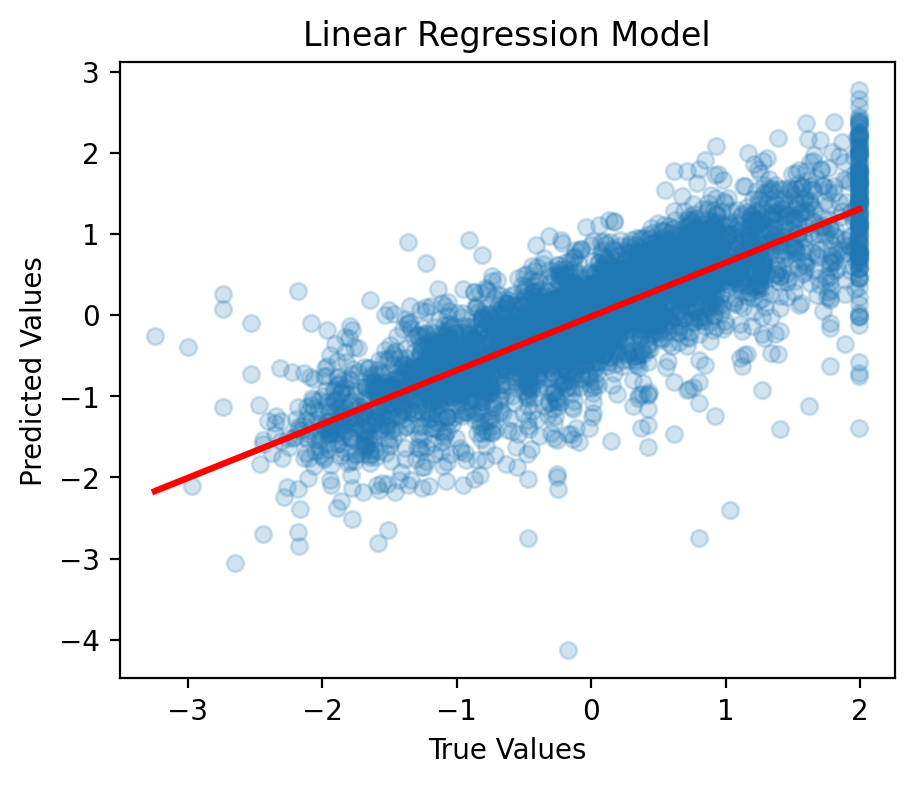

In [37]:
# graph the linear regression model against the target
plt.figure(figsize=(5, 4))
sns.regplot(
    x=model_result.y_test,
    y=model_result.test_preds,
    # color="blue",
    # marker=".",
    line_kws=dict(color="r"),
    scatter_kws=dict(alpha=0.2),
)

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression Model")
plt.show()

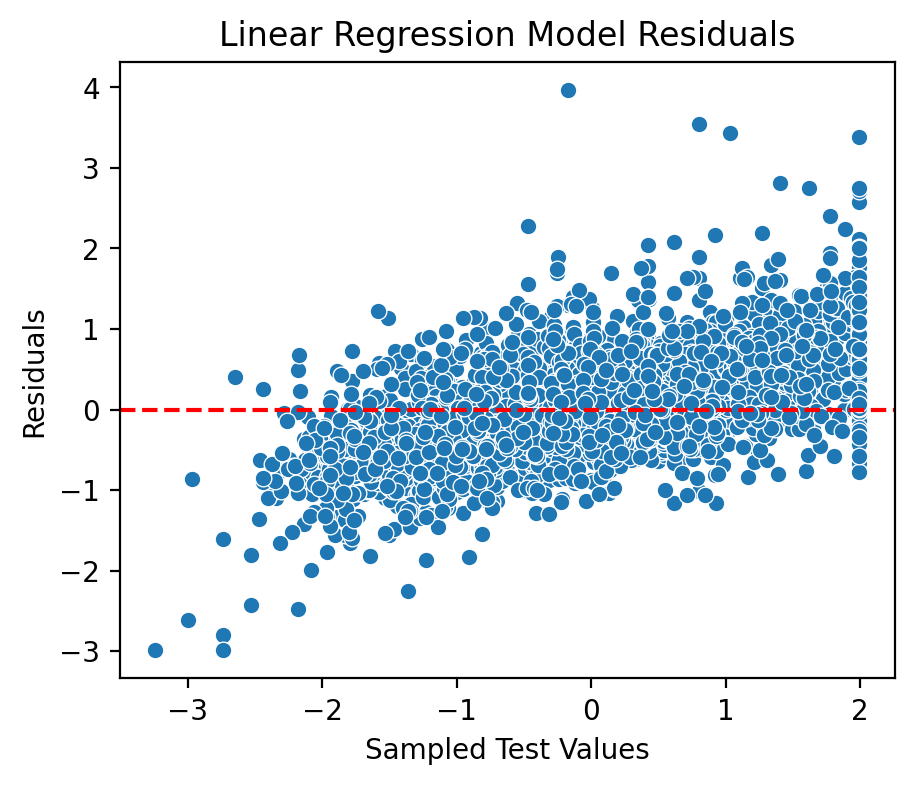

In [38]:
# graph the residuals
plt.figure(figsize=(5, 4))
sns.scatterplot(x=model_result.y_test, y=model_result.y_test - model_result.test_preds)
plt.xlabel("Sampled Test Values")
plt.ylabel("Residuals")
plt.title("Linear Regression Model Residuals")
plt.axhline(0, color="red", linestyle="--")

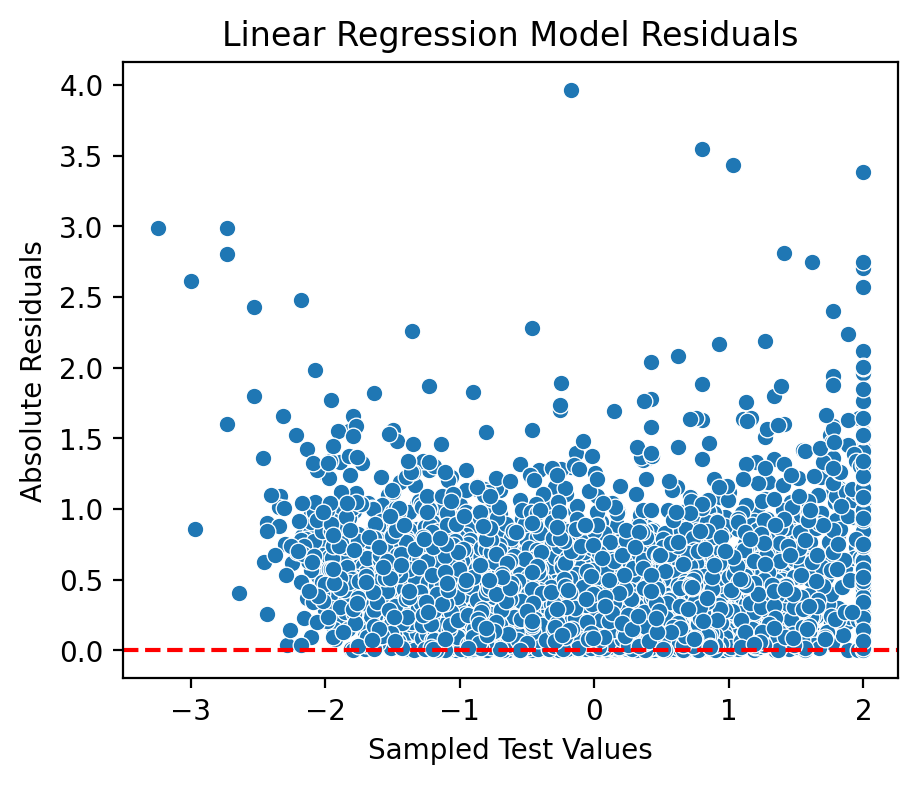

In [39]:
# graph the residuals
plt.figure(figsize=(5, 4))
sns.scatterplot(
    x=model_result.y_test, y=np.abs(model_result.y_test - model_result.test_preds)
)
plt.xlabel("Sampled Test Values")
plt.ylabel("Absolute Residuals")
plt.title("Linear Regression Model Residuals")
plt.axhline(0, color="red", linestyle="--")

Text(0.5, 1.0, 'Linear Regression Model Residuals')

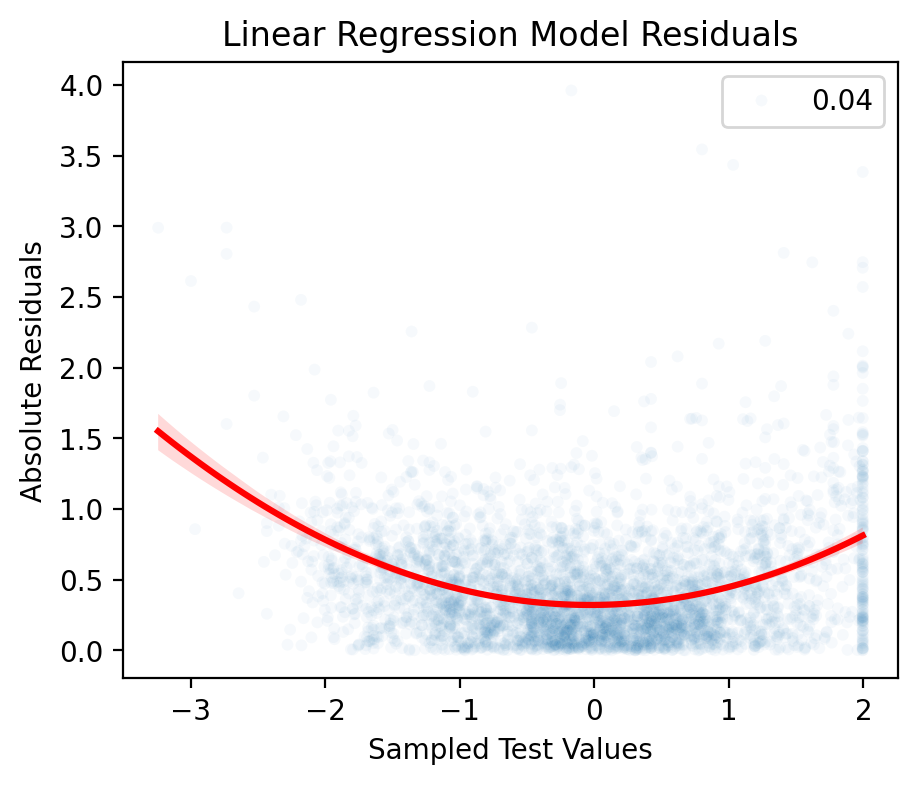

In [40]:
# grap the absolute residuals along with a polynomial fit
plt.figure(figsize=(5, 4))
sns.scatterplot(
    x=model_result.y_test,
    y=np.abs(model_result.y_test - model_result.test_preds),
    alpha=0.04,
    size=0.04,
)
sns.regplot(
    x=model_result.y_test,
    y=np.abs(model_result.y_test - model_result.test_preds),
    order=2,
    scatter=False,
    color="red",
)
plt.xlabel("Sampled Test Values")
plt.ylabel("Absolute Residuals")
plt.title("Linear Regression Model Residuals")

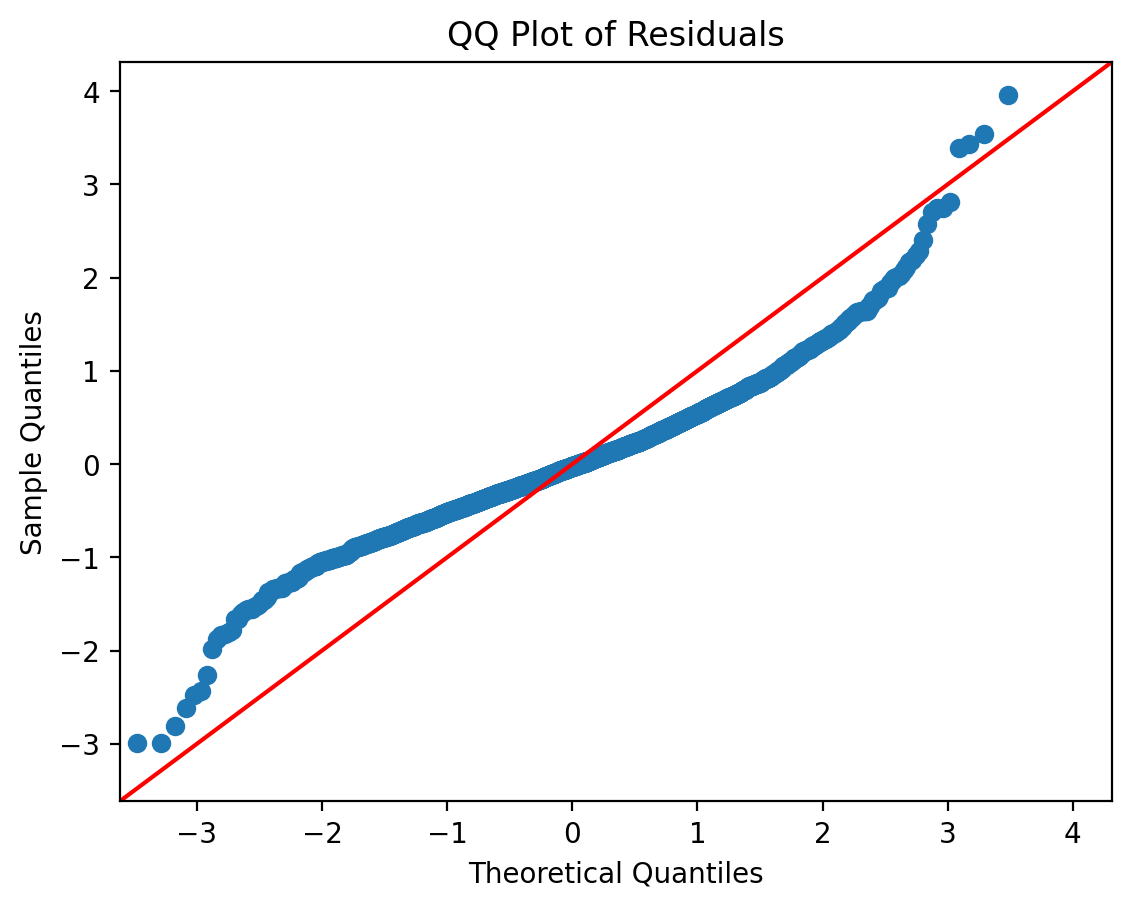

In [41]:
# QQ plot
import scipy.stats as stats
import statsmodels.api as sm

residuals = model_result.y_test - model_result.test_preds
sm.qqplot(residuals, line="45")
plt.title("QQ Plot of Residuals")
plt.show()

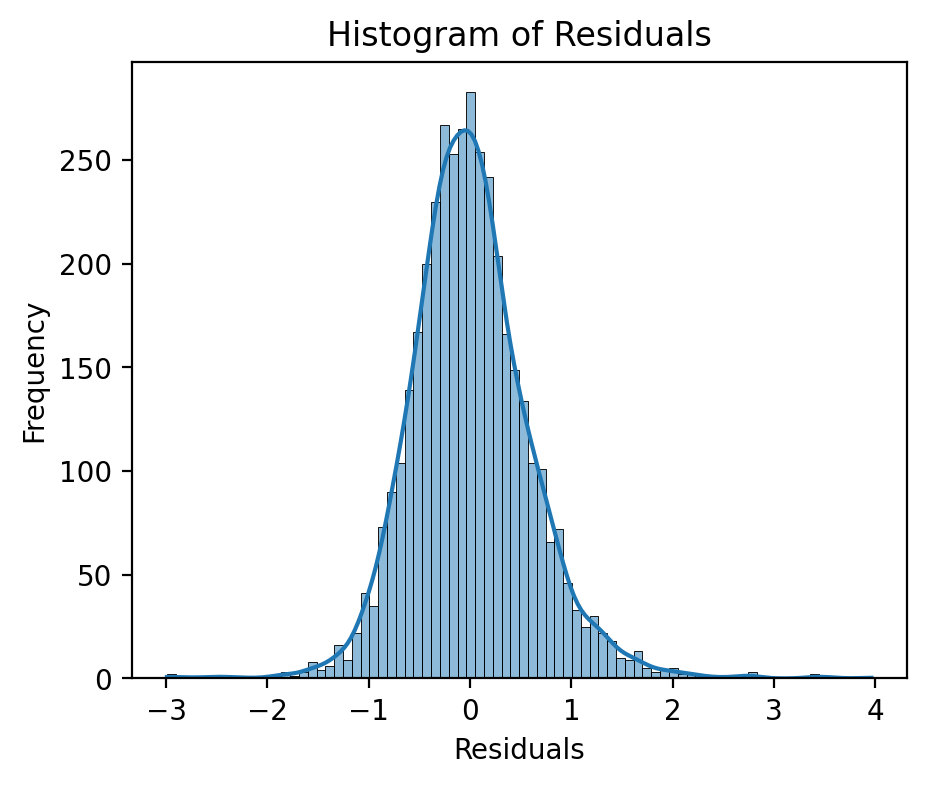

In [42]:
# histogram of the residuals
plt.figure(figsize=(5, 4))
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()